<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils import data as Data
import numpy as np

In [ ]:
d_model = 512 # embedding size
max_len = 1024 # max length of sequence
d_ff = 2048 # feedforward nerual network  dimension
d_k = d_v = 64 # dimension of k(same as q) and v
n_layers = 6 # number of encoder and decoder layers
n_heads = 8 # number of heads in multihead attention
p_drop = 0.1 # propability of dropout

In [ ]:
def get_attn_pad_mask(seq_q, seq_k):
  '''
  Padding, because of unequal in source_len and target_len.

  parameters:
  seq_q: [batch, seq_len]
  seq_k: [batch, seq_len]

  return:
  mask: [batch, len_q, len_k]


  '''
  batch, len_q = seq_q.size()
  batch, len_k = seq_k.size()
  # we define index of PAD is 0, if tensor equals (zero) PAD tokens
  pad_attn_mask = seq_k.data.eq(0).unsqueeze(1) # [batch, 1, len_k]

  return pad_attn_mask.expand(batch, len_q, len_k) # [batch, len_q, len_k]

def get_attn_subsequent_mask(seq):
  '''
  Build attention mask matrix for decoder when it autoregressing.

  parameters:
  seq: [batch, target_len]

  return:
  subsequent_mask: [batch, target_len, target_len]
  '''
  attn_shape = [seq.size(0), seq.size(1), seq.size(1)] # [batch, target_len, target_len]
  subsequent_mask = np.triu(np.ones(attn_shape), k=1) # [batch, target_len, target_len]
  subsequent_mask = torch.from_numpy(subsequent_mask)

  return subsequent_mask # [batch, target_len, target_len]

$$
PE(pos, 2i) = \sin(pos / 10000^{\frac{2i}{d_{model}}}) \\
PE(pos, 2i+1) = \cos(pos / 10000^{\frac{2i}{d_{model}}})
$$

In [ ]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model, dropout=.1, max_len=1024):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=p_drop)

    positional_encoding = torch.zeros(max_len, d_model) # [max_len, d_model]
    position = torch.arange(0, max_len).float().unsqueeze(1) # [max_len, 1]

    div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                         (-torch.log(torch.Tensor([10000])) / d_model)) # [max_len / 2]

    positional_encoding[:, 0::2] = torch.sin(position * div_term) # even
    positional_encoding[:, 1::2] = torch.cos(position * div_term) # odd

    # [max_len, d_model] -> [1, max_len, d_model] -> [max_len, 1, d_model]
    positional_encoding = positional_encoding.unsqueeze(0).transpose(0, 1)

    # register pe to buffer and require no grads
    self.register_buffer('pe', positional_encoding)

  def forward(self, x):
    # x: [seq_len, batch, d_model]
    # we can add positional encoding to x directly, and ignore other dimension
    x = x + self.pe[:x.size(0), ...]

    return self.dropout(x)

In [ ]:
class Seq2SeqDataset(Data.Dataset):

  def __init__(self, encoder_input, decoder_input, decoder_output):
    super(Seq2SeqDataset, self).__init__()
    self.encoder_input = encoder_input
    self.decoder_input = decoder_input
    self.decoder_output = decoder_output

  def __len__(self):
    return self.encoder_input.shape[0]

  def __getitem__(self, idx):
    return self.encoder_input[idx], self.decoder_input[idx], self.decoder_output[idx]

$$
\operatorname{Attention}(Q, K, V) = \operatorname{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

In [ ]:
class ScaledDotProductAttention(nn.Module):

  def __init__(self):
    super(ScaledDotProductAttention, self).__init__()

  def forward(self, Q, K, V, attn_mask):
    '''
    Q: [batch, n_heads, len_q, d_k]
    K: [batch, n_heads, len_k, d_k]
    V: [batch, n_heads, len_v, d_v]
    attn_mask: [batch, n_heads, seq_len, seq_len]
    '''
    scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # [batch, n_heads, len_q, len_k]
    scores.masked_fill_(attn_mask, -1e9)

    attn = nn.Softmax(dim=-1)(scores) # [batch, n_heads, len_q, len_k]
    prob = torch.matmul(attn, V) # [batch, n_heads, len_q, d_v]
    return prob, attn


In [ ]:
# x = torch.Tensor([[1, 0, 2, 3], [2, 3, 1, 2]])
# mask = torch.BoolTensor([1, 0, 0, 0])
# x.masked_fill(mask, -1e9)

# x = torch.rand(2, 8, 3, 64)
# a, b = ScaledDotProductAttention()(x, x, x, x)
# a.size(), b.size()

$$
\begin{aligned}
\operatorname{MultiHead}(Q, K, V) &= \operatorname{Concat}(\text{head}_1, \text{head}_2, \dots, \text{head}_h)W^O \\
\text{where } \text{head}_i &= \operatorname{Attention}(QW^Q_i, KW^K_i, VW^V_i)
\end{aligned}
$$


In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, n_heads=8):
    super(MultiHeadAttention, self).__init__()
    # do not use more instance to implement multihead attention
    # it can be complete in one matrix
    self.n_heads = n_heads

    # we can't use bias because there is no bias term in formular
    self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
    self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
    self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
    self.fc = nn.Linear(d_v * n_heads, d_model, bias=False)
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self, input_Q, input_K, input_V, attn_mask):
    '''
    To make sure multihead attention can be used both in encoder and decoder,
    we use Q, K, V respectively.
    input_Q: [batch, len_q, d_model]
    input_K: [batch, len_k, d_model]
    input_V: [batch, len_v, d_model]
    '''
    residual, batch = input_Q, input_Q.size(0)

    # [batch, len_q, d_model] -- matmul W_Q --> [batch, len_q, d_q * n_heads] -- view -->
    # [batch, len_q, n_heads, d_k,] -- transpose --> [batch, n_heads, len_q, d_k]

    Q = self.W_Q(input_Q).view(batch, -1, n_heads, d_k).transpose(1, 2) # [batch, n_heads, len_q, d_k]
    K = self.W_K(input_K).view(batch, -1, n_heads, d_k).transpose(1, 2) # [batch, n_heads, len_k, d_k]
    V = self.W_V(input_V).view(batch, -1, n_heads, d_v).transpose(1, 2) # [batch, n_heads, len_v, d_v]

    attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # [batch, n_heads, seq_len, seq_len]

    # prob: [batch, n_heads, len_q, d_v] attn: [batch, n_heads, len_q, len_k]
    prob, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)

    prob = prob.transpose(1, 2).contiguous() # [batch, len_q, n_heads, d_v]
    prob = prob.view(batch, -1, n_heads * d_v).contiguous() # [batch, len_q, n_heads * d_v]

    output = self.fc(prob) # [batch, len_q, d_model]

    return self.layer_norm(residual + output), attn


$$
\operatorname{FFN}(x)=\operatorname{ReLU}(xW_1+b_1)W_2 + b_2
$$

In [ ]:
class FeedForwardNetwork(nn.Module):
  '''
  Using nn.Conv1d replace nn.Linear to implements FFN.
  '''
  def __init__(self):
    super(FeedForwardNetwork, self).__init__()
    # self.ff1 = nn.Linear(d_model, d_ff)
    # self.ff2 = nn.Linear(d_ff, d_model)
    self.ff1 = nn.Conv1d(d_model, d_ff, 1)
    self.ff2 = nn.Conv1d(d_ff, d_model, 1)
    self.relu = nn.ReLU()

    self.dropout = nn.Dropout(p=p_drop)
    self.layer_norm = nn.LayerNorm(d_model)

  def forward(self, x):
    # x: [batch, seq_len, d_model]
    residual = x
    x = x.transpose(1, 2) # [batch, d_model, seq_len]
    x = self.ff1(x)
    x = self.relu(x)
    x = self.ff2(x)
    x = x.transpose(1, 2) # [batch, seq_len, d_model]

    return self.layer_norm(residual + x)

In [ ]:
# x = torch.rand(1024, 512).unsqueeze(1)
# f = FeedForwardNetwork()
# f(x).size()

# nn.Linear(512, 2048)(x).size()

In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self):
    super(EncoderLayer, self).__init__()
    self.encoder_self_attn = MultiHeadAttention()
    self.ffn = FeedForwardNetwork()

  def forward(self, encoder_input, encoder_pad_mask):
    '''
    encoder_input: [batch, source_len, d_model]
    encoder_pad_mask: [batch, n_heads, source_len, source_len]

    encoder_output: [batch, source_len, d_model]
    attn: [batch, n_heads, source_len, source_len]
    '''
    encoder_output, attn = self.encoder_self_attn(encoder_input, encoder_input, encoder_input, encoder_pad_mask)
    encoder_output = self.ffn(encoder_output) # [batch, source_len, d_model]

    return encoder_output, attn

class DecoderLayer(nn.Module):

  def __init__(self):
    super(DecoderLayer, self).__init__()
    self.decoder_self_attn = MultiHeadAttention()
    self.encoder_decoder_attn = MultiHeadAttention()
    self.ffn = FeedForwardNetwork()

  def forward(self, decoder_input, encoder_output, decoder_self_mask, decoder_encoder_mask):
    '''
    decoder_input: [batch, target_len, d_mdoel]
    encoder_output: [batch, source_len, d_model]
    decoder_self_mask: [batch, target_len, target_len]
    decoder_encoder_mask: [batch, target_len, source_len]
    '''
    # masked mutlihead attention
    # Q, K, V all from decoder it self
    # decoder_output: [batch, target_len, d_model]
    # decoder_self_attn: [batch, n_heads, target_len, target_len]
    decoder_output, decoder_self_attn = self.decoder_self_attn(decoder_input, decoder_input, decoder_input, decoder_self_mask)

    # Q from decoder, K, V from encoder
    # decoder_output: [batch, target_len, d_model]
    # decoder_encoder_attn: [batch, n_heads, target_len, source_len]
    decoder_output, decoder_encoder_attn = self.encoder_decoder_attn(decoder_input, encoder_output, encoder_output, decoder_encoder_mask)
    decoder_output = self.ffn(decoder_output) # [batch, target_len, d_model]

    return decoder_output, decoder_self_attn, decoder_encoder_attn


class Encoder(nn.Module):

  def __init__(self):
    super(Encoder, self).__init__()
    self.source_embedding = nn.Embedding(source_vocab_size, d_model)
    self.positional_embedding = PositionalEncoding(d_model)
    self.layers = nn.ModuleList([EncoderLayer() for layer in range(n_layers)])

  def forward(self, encoder_input):
    # encoder_input: [batch, source_len]
    encoder_output = self.source_embedding(encoder_input) # [batch, source_len, d_model]
    encoder_output = self.positional_embedding(encoder_output.transpose(0, 1)).transpose(0, 1) # [batch, source_len, d_model]

    encoder_self_attn_mask = get_attn_pad_mask(encoder_input, encoder_input) # [batch, source_len, source_len]
    encoder_self_attns = list()
    for layer in self.layers:
      # encoder_output: [batch, source_len, d_model]
      # encoder_self_attn: [batch, n_heads, source_len, source_len]
      encoder_output, encoder_self_attn = layer(encoder_output, encoder_self_attn_mask)
      encoder_self_attns.append(encoder_self_attn)

    return encoder_output, encoder_self_attns

class Decoder(nn.Module):

  def __init__(self):
    super(Decoder, self).__init__()
    self.target_embedding = nn.Embedding(target_vocab_size, d_model)
    self.positional_embedding = PositionalEncoding(d_model)
    self.layers = nn.ModuleList([DecoderLayer() for layer in range(n_layers)])

  def forward(self, decoder_input, encoder_input, encoder_output):
    '''
    decoder_input: [batch, target_len]
    encoder_input: [batch, source_len]
    encoder_output: [batch, source_len, d_model]
    '''
    decoder_output = self.target_embedding(decoder_input) # [batch, target_len, d_model]
    decoder_output = self.positional_embedding(decoder_output.transpose(0, 1)).transpose(0, 1) # [batch, target_len, d_model]
    decoder_self_attn_mask = get_attn_pad_mask(decoder_input, decoder_input) # [batch, target_len, d_model]
    decoder_subsequent_mask = get_attn_subsequent_mask(decoder_input) # [batch, target_len, target_len]

    decoder_encoder_attn_mask = get_attn_pad_mask(decoder_input, encoder_input) # [batch, target_len, source_len]

    decoder_self_mask = torch.gt(decoder_self_attn_mask + decoder_subsequent_mask, 0)
    decoder_self_attns, decoder_encoder_attns = [], []

    for layer in self.layers:
      # decoder_output: [batch, target_len, d_model]
      # decoder_self_attn: [batch, n_heads, target_len, target_len]
      # decoder_encoder_attn: [batch, n_heads, target_len, source_len]
      decoder_output, decoder_self_attn, decoder_encoder_attn = layer(decoder_output, encoder_output, decoder_self_mask, decoder_encoder_attn_mask)
      decoder_self_attns.append(decoder_self_attn)
      decoder_encoder_attns.append(decoder_encoder_attn)

    return decoder_output, decoder_self_attns, decoder_encoder_attns

In [ ]:
x = torch.Tensor([1, 0, 1, 0])
torch.gt(x + torch.Tensor([0, 1, 0, 0]), 0)

tensor([ True,  True,  True, False])

In [ ]:
class Transformer(nn.Module):

  def __init__(self):
    super(Transformer, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()
    self.projection = nn.Linear(d_model, target_vocab_size, bias=False)

  def forward(self, encoder_input, decoder_input):
    '''
    encoder_input: [batch, source_len]
    decoder_input: [batch, target_len]
    '''
    # encoder_output: [batch, source_len, d_model]
    # encoder_attns: [n_layers, batch, n_heads, source_len, source_len]
    encoder_output, encoder_attns = self.encoder(encoder_input)
    # decoder_output: [batch, target_len, d_model]
    # decoder_self_attns: [n_layers, batch, n_heads, target_len, target_len]
    # decoder_encoder_attns: [n_layers, batch, n_heads, target_len, source_len]
    decoder_output, decoder_self_attns, decoder_encoder_attns = self.decoder(decoder_input, encoder_input, encoder_output)
    decoder_logits = self.projection(decoder_output) # [batch, target_len, target_vocab_size]

    # decoder_logits: [batch * target_len, target_vocab_size]
    return decoder_logits.view(-1, decoder_logits.size(-1)), encoder_attns, decoder_self_attns, decoder_encoder_attns

In [ ]:
sentences = [
        # enc_input           dec_input         dec_output
        ['ich mochte ein bier P', 'S i want a beer .', 'i want a beer . E'],
        ['ich mochte ein cola P', 'S i want a coke .', 'i want a coke . E']
]

# Padding Should be Zero
source_vocab = {'P' : 0, 'ich' : 1, 'mochte' : 2, 'ein' : 3, 'bier' : 4, 'cola' : 5}
source_vocab_size = len(source_vocab)

target_vocab = {'P' : 0, 'i' : 1, 'want' : 2, 'a' : 3, 'beer' : 4, 'coke' : 5, 'S' : 6, 'E' : 7, '.' : 8}
idx2word = {i: w for i, w in enumerate(target_vocab)}
target_vocab_size = len(target_vocab)
source_len = 5 # max length of input sequence
target_len = 6

In [ ]:
def make_data(sentences):
  encoder_inputs, decoder_inputs, decoder_outputs = [], [], []
  for i in range(len(sentences)):
    encoder_input = [source_vocab[word] for word in sentences[i][0].split()]
    decoder_input = [target_vocab[word] for word in sentences[i][1].split()]
    decoder_output = [target_vocab[word] for word in sentences[i][2].split()]
    encoder_inputs.append(encoder_input)
    decoder_inputs.append(decoder_input)
    decoder_outputs.append(decoder_output)

  return torch.LongTensor(encoder_inputs), torch.LongTensor(decoder_inputs), torch.LongTensor(decoder_outputs)

In [ ]:
batch_size = 64
epochs = 32
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer().to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=lr)
encoder_inputs, decoder_inputs, decoder_outputs = make_data(sentences)
dataset = Seq2SeqDataset(encoder_inputs, decoder_inputs, decoder_outputs)
data_loader = Data.DataLoader(dataset, 2, True)

In [ ]:
for epoch in range(epochs):
  '''
  encoder_input: [batch, source_len]
  decoder_input: [batch, target_len]
  decoder_ouput: [batch, target_len]
  '''
  for encoder_input, decoder_input, decoder_output in data_loader:
    encoder_input = encoder_input.to(device)
    decoder_input = decoder_input.to(device)
    decoder_output = decoder_output.to(device)

    output, encoder_attns, decoder_attns, decoder_encoder_attns = model(encoder_input, decoder_input)
    loss = criterion(output, decoder_output.view(-1))

    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0001 loss = 2.210672
Epoch: 0002 loss = 0.871125
Epoch: 0003 loss = 1.653220
Epoch: 0004 loss = 1.280224
Epoch: 0005 loss = 2.761842
Epoch: 0006 loss = 3.543098
Epoch: 0007 loss = 3.537732
Epoch: 0008 loss = 1.724109
Epoch: 0009 loss = 1.223293
Epoch: 0010 loss = 1.135749
Epoch: 0011 loss = 1.083706
Epoch: 0012 loss = 0.908158
Epoch: 0013 loss = 0.521601
Epoch: 0014 loss = 0.330823
Epoch: 0015 loss = 0.268935
Epoch: 0016 loss = 0.227477
Epoch: 0017 loss = 0.200834
Epoch: 0018 loss = 0.209180
Epoch: 0019 loss = 0.188584
Epoch: 0020 loss = 0.166680
Epoch: 0021 loss = 0.157806
Epoch: 0022 loss = 0.137217
Epoch: 0023 loss = 0.128506
Epoch: 0024 loss = 0.127341
Epoch: 0025 loss = 0.127648
Epoch: 0026 loss = 0.126985
Epoch: 0027 loss = 0.128219
Epoch: 0028 loss = 0.132057
Epoch: 0029 loss = 0.125822
Epoch: 0030 loss = 0.125888
Epoch: 0031 loss = 0.125317
Epoch: 0032 loss = 0.121148


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

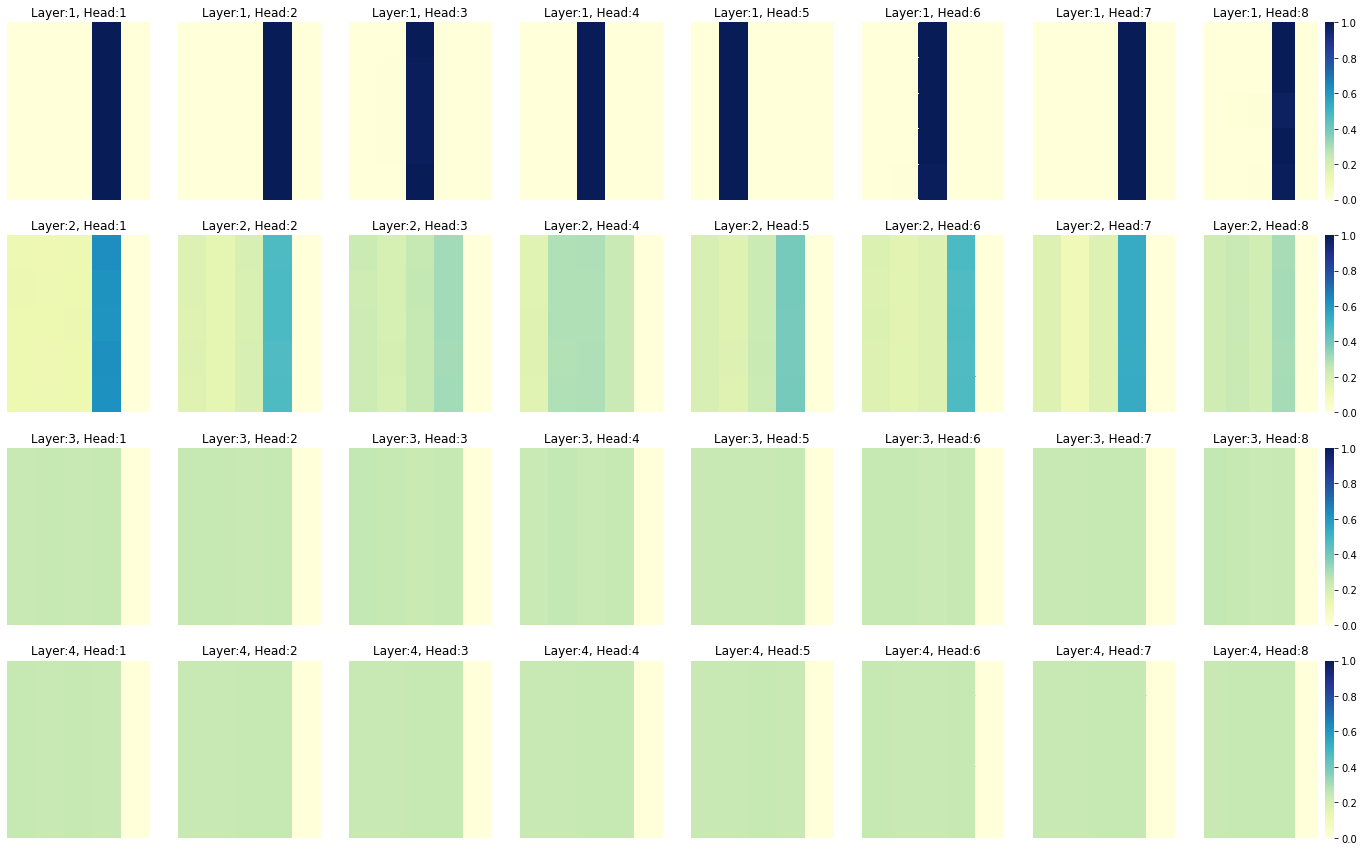

In [ ]:
n_layers = 4
'''
batch 1:
[[1, 2, 3, 5, 0],
[1, 2, 3, 4, 0]]
'''
temp_batch = 0
plt.figure(figsize=(n_heads * 3, n_layers * 3 + 3))
# encoder_attns: [n_layers, batch, n_heads, source_len, source_len]
i = 0
tokens = sentences[temp_batch][0].split()
for layer in range(n_layers):
  for head in range(n_heads):
    i += 1
    plt.subplot(n_layers, n_heads, i)

    plt.title('Layer:{}, Head:{}'.format(layer+1, head+1))
    if i % n_heads == 0:
      cbar=True
    else:
      cbar=False
    sns.heatmap(encoder_attns[layer][temp_batch][head].detach().numpy(), cmap='YlGnBu',
            xticklabels=tokens, yticklabels=tokens, cbar=cbar, vmin=0, vmax=1);
    plt.xticks([])
    plt.yticks([])

In [ ]:
def greedy_search(model, encoder_input, start_symbol=target_vocab['S']):
  '''
  One sentence.
  '''

  # init for decoder
  encoder_output, encoder_self_attns = model.encoder(encoder_input)
  decoder_input = torch.zeros(1, target_len).type_as(encoder_input.data)
  next_symbol = start_symbol

  for i in range(target_len):
    decoder_input[0][i] = next_symbol
    # decoder_output: [batch(1), target_len, d_model]
    decoder_output, _, _ = model.decoder(decoder_input, encoder_input, encoder_output)
    projected = model.projection(decoder_output) # [batch, target_len, target_vocab_len]
    projected = projected.squeeze(0) # [target_len, target_vocab_len]
    prob = projected.max(dim=1, keepdim=False)[1]
    next_symbol = prob.data[i].item()

  return decoder_input

In [ ]:
model.eval()
with torch.no_grad():
  encoder_input, _, _ = next(iter(data_loader))
  greedy_decoder_input = greedy_search(model, encoder_input[0].view(1, -1))
  predict, _, _, _ = model(encoder_input[0].view(1, -1), greedy_decoder_input)
  predict = predict.data.max(1, keepdim=True)[1]
  print(encoder_input[0], '->', [idx2word[n.item()] for n in predict.squeeze()])

In [ ]:
def beam_search(model, encoder_input, beam=3, start_symbol=target_vocab['S']):
  '''
  Beam search.
  '''
  pass